In [3]:
!pip install psycopg2-binary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 632.6 kB/s eta 0:00:0000:0100:01


In [6]:
import pandas as pd
import numpy as np
import psycopg2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [7]:
# Connect to PostgreSQL (from inside Docker)
conn = psycopg2.connect(
    host="postgres",  # ← Container name (not localhost!)
    port=5432,
    database="traffic_noise_db",
    user="traffic_user",
    password="traffic_pass"
)

print("✅ Connected to PostgreSQL")

# Load data directly
query = """
SELECT 
    timestamp,
    sensor_id,
    street_name,
    neighborhood,
    latitude,
    longitude,
    noise_level,
    EXTRACT(HOUR FROM timestamp) as hour,
    EXTRACT(DOW FROM timestamp) as day_of_week
FROM noise_readings
ORDER BY timestamp
"""

# Read into pandas
df = pd.read_sql(query, conn)
conn.close()

print(f"✅ Loaded {len(df):,} readings")
print(f"   Sensors: {df['sensor_id'].nunique()}")
print(f"   Columns: {list(df.columns)}")

# Show data
df.head()

✅ Connected to PostgreSQL


/tmp/ipykernel_178/31048876.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ Loaded 60,770 readings
   Sensors: 10
   Columns: ['timestamp', 'sensor_id', 'street_name', 'neighborhood', 'latitude', 'longitude', 'noise_level', 'hour', 'day_of_week']


,timestamp,sensor_id,street_name,neighborhood,latitude,longitude,noise_level,hour,day_of_week
0,2025-12-06 14:41:20.902811+00:00,SENSOR_001,Evening Street,Tsehay Kebele,9.594669,41.860859,76.3,14.0,6.0
1,2025-12-06 14:41:20.902811+00:00,SENSOR_002,University Avenue,Ganda Hassandana,9.567821,41.865903,69.8,14.0,6.0
2,2025-12-06 14:41:20.902811+00:00,SENSOR_003,Victory Street,Tsehay Kebele,9.617637,41.863028,69.0,14.0,6.0
3,2025-12-06 14:41:20.902811+00:00,SENSOR_004,Addis Ababa Road,Commercial District,9.611810,41.854226,89.7,14.0,6.0
4,2025-12-06 14:41:20.902811+00:00,SENSOR_005,Evening Street,Ganda Harla,9.621982,41.896238,67.0,14.0,6.0


## Feature Engineering

In [8]:
# Temporal features
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

# Cyclical encoding for hour (important!)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Location encoding
df['sensor_encoded'] = df['sensor_id'].astype('category').cat.codes
df['neighborhood_encoded'] = df['neighborhood'].astype('category').cat.codes

## Prepare Training Data

In [9]:
# Select features
features = [
    'hour', 
    'day_of_week', 
    'is_weekend', 
    'is_rush_hour',
    'hour_sin', 
    'hour_cos',
    'sensor_encoded', 
    'neighborhood_encoded'
]

X = df[features]
y = df['noise_level']

print(f"\nTraining data shape:")
print(f"   X: {X.shape}")
print(f"   y: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nSplit data:")
print(f"   Training: {len(X_train):,} samples")
print(f"   Testing: {len(X_test):,} samples")


Training data shape:
   X: (60770, 8)
   y: (60770,)

Split data:
   Training: 48,616 samples
   Testing: 12,154 samples


## Train Random Forest Model

In [10]:
model = RandomForestRegressor(
    n_estimators=100,      # 100 trees
    max_depth=10,          # Max depth
    min_samples_split=5,   # Min samples to split
    random_state=42,
    n_jobs=-1,             # Use all CPU cores
    verbose=1              # Show progress
)

# Train
model.fit(X_train, y_train)

print("\nModel trained!")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s



Model trained!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished


## Evaluate Model

In [11]:
# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Metrics - Training
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

# Metrics - Testing
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("\n" + "="*60)
print("🎯 MODEL PERFORMANCE")
print("="*60)
print("\n📈 Training Set:")
print(f"   MAE:  {mae_train:.2f} dB")
print(f"   RMSE: {rmse_train:.2f} dB")
print(f"   R²:   {r2_train:.4f}")
print(f"   Accuracy: {(1 - mae_train/y_train.mean())*100:.1f}%")

print("\n📉 Testing Set:")
print(f"   MAE:  {mae_test:.2f} dB")
print(f"   RMSE: {rmse_test:.2f} dB")
print(f"   R²:   {r2_test:.4f}")
print(f"   Accuracy: {(1 - mae_test/y_test.mean())*100:.1f}%")
print("="*60)


🎯 MODEL PERFORMANCE

📈 Training Set:
   MAE:  3.72 dB
   RMSE: 4.41 dB
   R²:   0.8705
   Accuracy: 95.4%

📉 Testing Set:
   MAE:  3.74 dB
   RMSE: 4.45 dB
   R²:   0.8692
   Accuracy: 95.4%


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


## Feature Importance

In [12]:
print("\nFeature Importance:")
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.to_string(index=False))


Feature Importance:
             feature  importance
neighborhood_encoded    0.445994
      sensor_encoded    0.401741
            hour_sin    0.051280
                hour    0.037684
            hour_cos    0.019406
          is_weekend    0.014882
        is_rush_hour    0.014692
         day_of_week    0.014322


## Visualizations

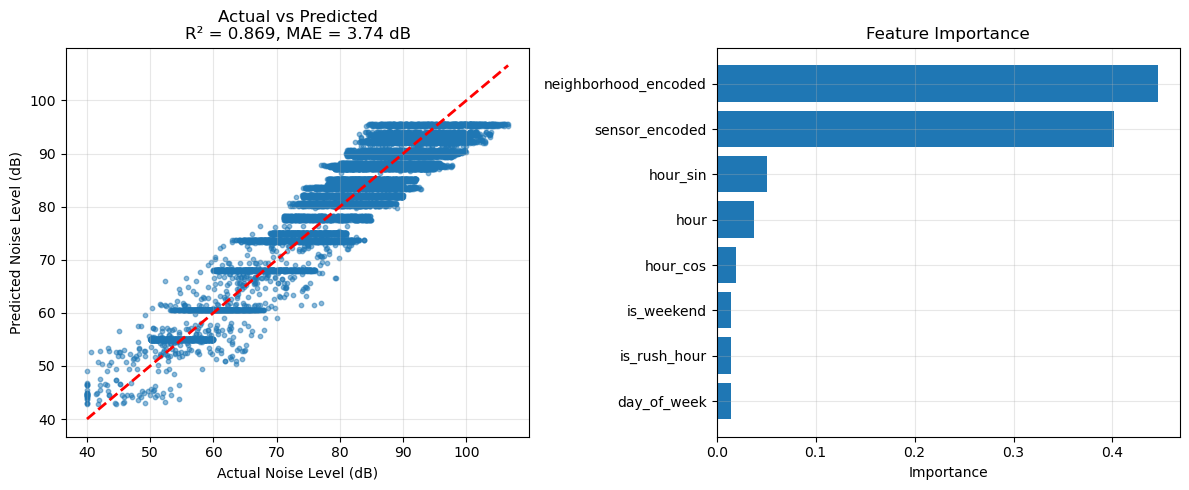

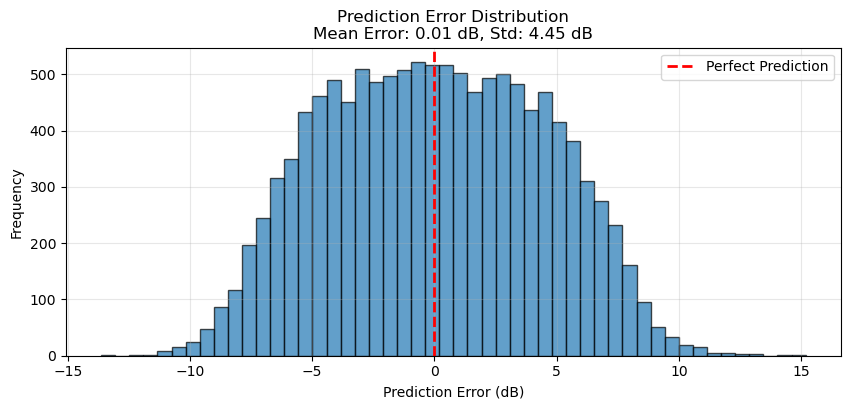

In [13]:
# Plot 1: Actual vs Predicted
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Noise Level (dB)')
plt.ylabel('Predicted Noise Level (dB)')
plt.title(f'Actual vs Predicted\nR² = {r2_test:.3f}, MAE = {mae_test:.2f} dB')
plt.grid(True, alpha=0.3)

# Plot 2: Feature Importance
plt.subplot(1, 2, 2)
feature_importance_sorted = feature_importance.sort_values('importance')
plt.barh(feature_importance_sorted['feature'], feature_importance_sorted['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 3: Prediction Error Distribution
plt.figure(figsize=(10, 4))
errors = y_test - y_pred_test
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (dB)')
plt.ylabel('Frequency')
plt.title(f'Prediction Error Distribution\nMean Error: {errors.mean():.2f} dB, Std: {errors.std():.2f} dB')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
model_filename = f'noise_predictor_rf_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl'
joblib.dump(model, model_filename)

print(f"\nModel saved: {model_filename}")

# Also save feature names for later use
feature_info = {
    'features': features,
    'sensor_mapping': dict(zip(df['sensor_id'].astype('category').cat.codes, df['sensor_id'])),
    'neighborhood_mapping': dict(zip(df['neighborhood'].astype('category').cat.codes, df['neighborhood']))
}
joblib.dump(feature_info, f'feature_info_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl')

print(f"Feature info saved")


Model saved: noise_predictor_rf_20251207_221717.pkl
Feature info saved
